In [1]:
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors

num_atom_feat = 34
def one_of_k_encoding(x, allowable_set):
    if x not in allowable_set:
        raise Exception("input {0} not in allowable set{1}:".format(
            x, allowable_set))
    return [x == s for s in allowable_set]


def one_of_k_encoding_unk(x, allowable_set):
    """Maps inputs not in the allowable set to the last element."""
    if x not in allowable_set:
        x = allowable_set[-1]
    return [x == s for s in allowable_set]


def atom_features(atom,explicit_H=False,use_chirality=True):
    """Generate atom features including atom symbol(10),degree(7),formal charge,
    radical electrons,hybridization(6),aromatic(1),Chirality(3)
    """
    symbol = ['C', 'N', 'O', 'F', 'P', 'S', 'Cl', 'Br', 'I', 'other']  # 10-dim
    degree = [0, 1, 2, 3, 4, 5, 6]  # 7-dim
    hybridizationType = [Chem.rdchem.HybridizationType.SP,
                              Chem.rdchem.HybridizationType.SP2,
                              Chem.rdchem.HybridizationType.SP3,
                              Chem.rdchem.HybridizationType.SP3D,
                              Chem.rdchem.HybridizationType.SP3D2,
                              'other']   # 6-dim
    results = one_of_k_encoding_unk(atom.GetSymbol(),symbol) + \
                  one_of_k_encoding(atom.GetDegree(),degree) + \
                  [atom.GetFormalCharge(), atom.GetNumRadicalElectrons()] + \
                  one_of_k_encoding_unk(atom.GetHybridization(), hybridizationType) + [atom.GetIsAromatic()]  # 10+7+2+6+1=26

    # In case of explicit hydrogen(QM8, QM9), avoid calling `GetTotalNumHs`
    if not explicit_H:
        results = results + one_of_k_encoding_unk(atom.GetTotalNumHs(),
                                                      [0, 1, 2, 3, 4])   # 26+5=31
    if use_chirality:
        try:
            results = results + one_of_k_encoding_unk(
                    atom.GetProp('_CIPCode'),
                    ['R', 'S']) + [atom.HasProp('_ChiralityPossible')]
        except:
            results = results + [False, False] + [atom.HasProp('_ChiralityPossible')]  # 31+3 =34
    return results


def adjacent_matrix(mol):
    adjacency = Chem.GetAdjacencyMatrix(mol)
    return np.array(adjacency)


def mol_features(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
    except:
        raise RuntimeError("SMILES cannot been parsed!")
    mol = Chem.AddHs(mol)
    atom_feat = np.zeros((mol.GetNumAtoms(), num_atom_feat))
    for atom in mol.GetAtoms():
        atom_feat[atom.GetIdx(), :] = atom_features(atom)
    adj_matrix = adjacent_matrix(mol)
    return atom_feat, adj_matrix

def load_tensor(file_name, dtype):
    return [dtype(d).to(device) for d in file_name]


In [2]:
from word2vec import seq_to_kmers, get_protein_embedding
from gensim.models import Word2Vec
import torch
import os

"""CPU or GPU"""
if torch.cuda.is_available():
    device = torch.device('cuda:0')
    print('The code uses GPU...')
else:
    device = torch.device('cpu')
    print('The code uses CPU!!!')

compounds, adjacencies,proteins,interactions = [], [], [], []
compound = "CN(C)CCCC1(c2ccc(F)cc2)OCc2cc(C#N)ccc21"
atom_feature ,adj = mol_features(compound)
compounds.append(atom_feature)
adjacencies.append(adj)
adjacencies = np.array(adjacencies)
model = Word2Vec.load("word2vec_30.model")
sequence = "MSLPNSSCLLEDKMCEGNKTTMASPQLMPLVVVLSTICLVTVGLNLLVLYAVRSERKLHTVGNLYIVSLSVADLIVGAVVMPMNILYLLMSKWSLGRPLCLFWLSMDYVASTASIFSVFILCIDRYRSVQQPLRYLKYRTKTRASATILGAWFLSFLWVIPILGWNHFMQQTSVRREDKCETDFYDVTWFKVMTAIINFYLPTLLMLWFYAKIYKAVRQHCQHRELINRSLPSFSEIKLRPENPKGDAKKPGKESPWEVLKRKPKDAGGGSVLKSPSQTPKEMKSPVVFSQEDDREVDKLYCFPLDIVHMQAAAEGSSRDYVAVNRSHGQLKTDEQGLNTHGASEISEDQMLGDSQSFSRTDSDTTTETAPGKGKLRSGSNTGLDYIKFTWKRLRSHSRQYVSGLHMNRERKAAKQLGFIMAAFILCWIPYFIFFMVIAFCKNCCNEHLHMFTIWLGYINSTLNPLIYPLCNENFKKTFKRILHIRS"
protein_embedding = get_protein_embedding(model, seq_to_kmers(sequence))
proteins.append(protein_embedding)
interactions.append(np.array([0]))

compounds = load_tensor(compounds, torch.FloatTensor)
adjacencies = load_tensor(adjacencies.astype(np.float32), torch.FloatTensor)
proteins = load_tensor(proteins, torch.FloatTensor)
interactions = load_tensor(interactions, torch.LongTensor)

dataset = list(zip(compounds, adjacencies, proteins, interactions))

F:\anaconda\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


The code uses CPU!!!


F:\anaconda\lib\site-packages\smart_open\smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [3]:
from model_predict import *

""" create model ,trainer and tester """
protein_dim = 100
atom_dim = 34
hid_dim = 64
n_layers = 4
n_heads = 8
pf_dim = 256
dropout = 0.1
batch = 64
lr = 1e-4
weight_decay = 1e-4
decay_interval = 5
lr_decay = 1.0
iteration = 100
kernel_size = 7

encoder = Encoder(protein_dim, hid_dim, n_layers, kernel_size, dropout, device)
decoder = Decoder(atom_dim, hid_dim, n_layers, n_heads, pf_dim, DecoderLayer, SelfAttention, PositionwiseFeedforward, dropout, device)
model = Predictor(encoder, decoder, device)
model.load_state_dict(torch.load("lr=1e-4,dropout=0.1,weight_decay=1e-4,kernel=7,n_layer=4,batch=64",map_location = lambda storage,loc:storage))
model.to(device)

Predictor(
  (encoder): Encoder(
    (convs): ModuleList(
      (0): Conv1d(64, 128, kernel_size=(7,), stride=(1,), padding=(3,))
      (1): Conv1d(64, 128, kernel_size=(7,), stride=(1,), padding=(3,))
      (2): Conv1d(64, 128, kernel_size=(7,), stride=(1,), padding=(3,))
      (3): Conv1d(64, 128, kernel_size=(7,), stride=(1,), padding=(3,))
    )
    (dropout): Dropout(p=0.1)
    (fc): Linear(in_features=100, out_features=64, bias=True)
  )
  (decoder): Decoder(
    (ln): LayerNorm(torch.Size([64]), eps=1e-05, elementwise_affine=True)
    (sa): SelfAttention(
      (w_q): Linear(in_features=64, out_features=64, bias=True)
      (w_k): Linear(in_features=64, out_features=64, bias=True)
      (w_v): Linear(in_features=64, out_features=64, bias=True)
      (fc): Linear(in_features=64, out_features=64, bias=True)
      (do): Dropout(p=0.1)
    )
    (layers): ModuleList(
      (0): DecoderLayer(
        (ln): LayerNorm(torch.Size([64]), eps=1e-05, elementwise_affine=True)
        (sa): 

In [4]:
with torch.no_grad():
    model.eval()
    for data in dataset:
        predicted_scores,norm,trg,sum = model(data, train=False)
predicted_scores,norm

(0.37978753,
 tensor([0.0221, 0.0221, 0.0221, 0.0225, 0.0223, 0.0224, 0.0224, 0.0225, 0.0222,
         0.0222, 0.0223, 0.0223, 0.0222, 0.0222, 0.0222, 0.0221, 0.0225, 0.0222,
         0.0223, 0.0221, 0.0220, 0.0222, 0.0222, 0.0225, 0.0221, 0.0221, 0.0221,
         0.0221, 0.0221, 0.0221, 0.0221, 0.0221, 0.0221, 0.0221, 0.0221, 0.0221,
         0.0223, 0.0223, 0.0223, 0.0223, 0.0221, 0.0221, 0.0223, 0.0223, 0.0223]))

In [99]:
sum

tensor([[ 0.0130, -0.5352, -0.3507,  0.1420,  0.1622,  0.2389,  0.2534,  0.0915,
         -0.0164,  0.7527, -0.5606,  0.7433,  0.6455, -0.7754, -0.8588, -0.9015,
         -0.0828,  0.1390, -1.2350,  0.1251, -0.5996, -1.1045,  2.5030, -0.5014,
          1.7294,  0.0699,  0.3324, -1.1385,  0.6220,  0.0057, -1.6006, -0.8063,
         -0.0405, -0.7073, -0.9673, -0.3232,  1.2731, -1.1750, -0.6459, -0.4882,
         -0.1558,  0.2838,  0.7250,  0.7439, -1.2113, -0.2503, -1.1740,  1.2277,
          1.1049,  0.1444,  0.2178, -0.4480,  0.2795,  1.9362,  2.3614,  0.0345,
         -0.5818,  0.6369, -1.1539, -0.7636,  0.7040,  0.9029,  0.6139, -0.5196]])

In [100]:
trg

tensor([[ 1.1256,  0.3671, -0.3356,  ...,  0.7603, -1.5632,  0.0810],
        [-0.4350, -0.9232, -0.5582,  ...,  1.0355,  0.9460, -1.2479],
        [ 0.9992, -0.4320, -1.5532,  ..., -0.0176,  1.0689, -1.6585],
        ...,
        [-0.5149, -0.4737, -0.7096,  ...,  0.7278,  0.7670, -0.1749],
        [-0.5149, -0.4737, -0.7096,  ...,  0.7278,  0.7670, -0.1749],
        [-0.5149, -0.4737, -0.7096,  ...,  0.7278,  0.7670, -0.1749]])

# Calculate Cosine Similarity

In [101]:
sum = sum.reshape(-1).numpy()
trg = trg.numpy()

In [102]:
similarity = np.zeros(trg.shape[0])
for i in range(trg.shape[0]):
    candidate = trg[i,:]
    similarity[i] = np.dot(candidate,sum)/(np.linalg.norm(candidate)*(np.linalg.norm(sum)))
print(similarity)


[0.48520583 0.92314714 0.66674078 0.8763566  0.8763566  0.87463248
 0.7779395  0.88335323 0.80566061 0.75520253 0.84031916 0.69251096
 0.69251096 0.47375906 0.8763566  0.8763566  0.8763566  0.50375032
 0.88021386 0.8763566  0.8763566  0.92403746 0.92403746 0.92403746
 0.92842734 0.92842734 0.92403746 0.92403746 0.92403746 0.92403746
 0.92403746 0.92403746 0.92403746 0.92403746 0.92403746 0.92403746
 0.92403746 0.92403746 0.92842734 0.92842734 0.92842734 0.92842734
 0.92842734 0.92842734]


In [103]:
np.argsort(-similarity[:21])

array([ 1,  7, 18, 20,  3,  4, 16, 15, 14, 19,  5, 10,  8,  6,  9, 12, 11,
        2, 17,  0, 13], dtype=int64)

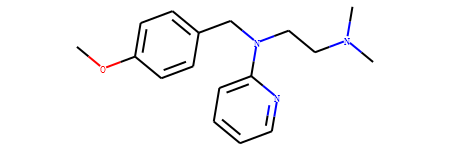

In [93]:
from rdkit.Chem import PyMol
from rdkit import Chem
import sys
from IPython.display import SVG
from rdkit import rdBase
from rdkit.Chem import AllChem, DataStructs
from rdkit.Chem.Draw import DrawMorganBit, DrawMorganBits,DrawMorganEnv, IPythonConsole
mol_1='COc1ccc(CN(CCN(C)C)c2ccccn2)cc1'
mol = Chem.MolFromSmiles(mol_1)
mol

In [94]:
def add_atom_index(mol):
    atoms = mol.GetNumAtoms()
    for i in range( atoms ):
        mol.GetAtomWithIdx(i).SetProp(
            'molAtomMapNumber', str(mol.GetAtomWithIdx(i).GetIdx()))
    return mol,atoms

21


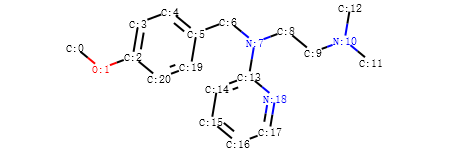

In [95]:
from rdkit.Chem import Draw
mols = []
mol,atoms = add_atom_index(mol)
print(atoms)
mol
#img = Draw.MolsToGridImage(mols, molsPerRow=1,subImgSize=(1200, 1200))
#img.save("negative-1.png")